In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
inputs = keras.Input(shape=(784,), name='img')
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')

In [6]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 5s 96us/sample - loss: 0.3451 - accuracy: 0.9027 - val_loss: 0.1848 - val_accuracy: 0.9437
Epoch 2/5
48000/48000 [==============================] - 3s 71us/sample - loss: 0.1627 - accuracy: 0.9519 - val_loss: 0.1388 - val_accuracy: 0.9582
Epoch 3/5
48000/48000 [==============================] - 3s 72us/sample - loss: 0.1177 - accuracy: 0.9643 - val_loss: 0.1245 - val_accuracy: 0.9638
Epoch 4/5
48000/48000 [==============================] - 3s 71us/sample - loss: 0.0943 - accuracy: 0.9725 - val_loss: 0.1130 - val_accuracy: 0.9680
Epoch 5/5
48000/48000 [==============================] - 3s 71us/sample - loss: 0.0791 - accuracy: 0.9764 - val_loss: 0.1143 - val_accuracy: 0.9668
Test loss: 0.10769689494292252
Test accuracy: 0.968


In [21]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

Manipulating complex graph topologies
===========

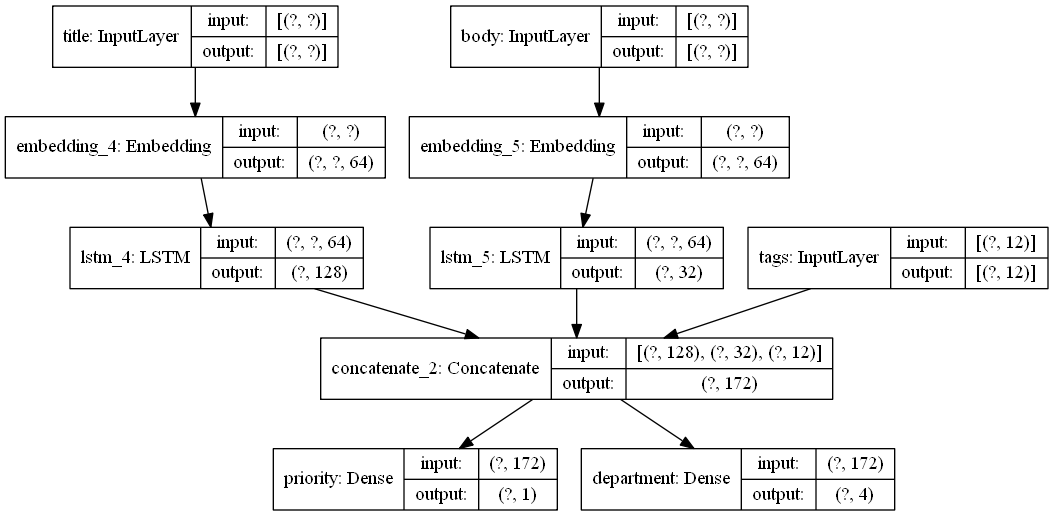

In [5]:
num_tags = 12  
num_words = 10000  
num_departments = 4  

title_input = keras.Input(shape=(None,), name='title')  
body_input = keras.Input(shape=(None,), name='body') 
tags_input = keras.Input(shape=(num_tags,), name='tags')


title_features = layers.Embedding(num_words, 64)(title_input)
body_features = layers.Embedding(num_words, 64)(body_input)

title_features = layers.LSTM(128)(title_features)
body_features = layers.LSTM(32)(body_features)

x = layers.concatenate([title_features, body_features, tags_input])

priority_pred = layers.Dense(1, activation='sigmoid', name='priority')(x)
department_pred = layers.Dense(num_departments, activation='softmax', name='department')(x)

model = keras.Model(inputs=[title_input, body_input, tags_input],
                    outputs=[priority_pred, department_pred])
#model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [6]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss=['binary_crossentropy', 'categorical_crossentropy'],
              loss_weights=[1., 0.2])
import numpy as np

# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype('float32')
# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit({'title': title_data, 'body': body_data, 'tags': tags_data},
          {'priority': priority_targets, 'department': dept_targets},
          epochs=2,
          batch_size=32)

Train on 1280 samples
Epoch 1/2
1280/1280 [==============================] - 6s 4ms/sample - loss: 1.2854 - priority_loss: 0.7059 - department_loss: 2.8976
Epoch 2/2
1280/1280 [==============================] - 3s 2ms/sample - loss: 1.2670 - priority_loss: 0.6975 - department_loss: 2.8472


In [5]:
import numpy as np
print(np.random.randint(2, size=(2, 5)))
print(np.random.random(size=(1280, 1)))

[[1 1 1 1 1]
 [1 1 0 0 1]]
[[0.00389536]
 [0.84744804]
 [0.70124002]
 ...
 [0.45712405]
 [0.64048114]
 [0.57202174]]


S&P 500 top companies
=======================

구글 아마존 애플 비자 마스타 어도비 마이크로소프트 등

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import numpy as np

In [2]:
D=[]
L=['AAPL','AMZN','BRK-B','FB','GOOG','GOOGL','JPM','MSFT','V']
maxdates=[]
for company in L:
    temp=np.genfromtxt('C:/Users/mod96/Desktop/HSH/DateSets/SP500top/'+company+'.csv', delimiter=',')
    temp2=np.size(temp,0)
    maxdates.append(temp2)
    D.append(temp[1:,1:])
maxdate=min(maxdates)

In [70]:
inputdata=[]
for i in range(len(L)):
    temp=maxdates[i]-maxdate
    temp2=maxdates[i]-1
    inputdata.append(D[i][temp:temp2,:])

In [155]:
for i in range(len(inputdata)):
    print(np.size(inputdata[i],0),np.size(inputdata[i],1))
print(max(inputdata))

1986 5
1986 5
1986 5
1986 5
1986 5
1986 5
1986 5
1986 5
1986 5


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [108]:
inputdatalstm=[]
for j in range(len(L)):
    inputdatalstm.append([])
    for i in range(np.size(inputdata[j],0)-50):
        k=i+50
        temp=inputdata[j][i:k,:]
        inputdatalstm[j].append(temp)

In [153]:
print(np.size(inputdatalstm,0),np.size(inputdatalstm,1))
print(inputdatalstm[0][0:2])

9 1936
[array([[7.6279999e+01, 7.7629997e+01, 7.4597145e+01, 7.5768570e+01,
        6.5770210e+01, 1.8307310e+08],
       [7.6357140e+01, 8.0220001e+01, 7.6292854e+01, 8.0182854e+01,
        6.9601997e+01, 1.5777650e+08],
       [8.1364288e+01, 8.1982857e+01, 7.8940002e+01, 7.9567146e+01,
        6.9067520e+01, 1.7371760e+08],
       [7.9642860e+01, 8.1828575e+01, 7.9032860e+01, 8.1508568e+01,
        7.0752777e+01, 1.4622440e+08],
       [8.2267143e+01, 8.2357140e+01, 8.0175713e+01, 8.0760002e+01,
        7.0102989e+01, 1.2405750e+08],
       [8.0655716e+01, 8.0835716e+01, 7.9781425e+01, 8.0327141e+01,
        6.9727234e+01, 8.2126800e+07],
       [8.1557144e+01, 8.2000000e+01, 8.0758568e+01, 8.1752853e+01,
        7.0964836e+01, 9.5127200e+07],
       [8.1314285e+01, 8.2855713e+01, 8.0937141e+01, 8.2738571e+01,
        7.1820480e+01, 1.3235740e+08],
       [8.2962860e+01, 8.3071426e+01, 8.1637146e+01, 8.2532860e+01,
        7.1641876e+01, 1.2291860e+08],
       [8.1308571e+01, 8.1807

In [143]:
temp=maxdates[0]-maxdate+51
outputdata=D[0][temp:,0]
outputdata=outputdata/max(outputdata)

In [144]:
print(np.size(outputdata,0))

1936


In [145]:
print(outputdata,inputdata)

[0.27094644 0.26519679 0.26994344 ... 0.80907803 0.82743124 0.82623023] [array([[7.62799990e+01, 7.76299970e+01, 7.45971450e+01, 7.57685700e+01,
        6.57702100e+01, 1.83073100e+08],
       [7.63571400e+01, 8.02200010e+01, 7.62928540e+01, 8.01828540e+01,
        6.96019970e+01, 1.57776500e+08],
       [8.13642880e+01, 8.19828570e+01, 7.89400020e+01, 7.95671460e+01,
        6.90675200e+01, 1.73717600e+08],
       ...,
       [2.70799988e+02, 2.71700012e+02, 2.59000000e+02, 2.59429993e+02,
        2.59429993e+02, 5.07218000e+07],
       [2.62739990e+02, 2.67369995e+02, 2.61230011e+02, 2.66070007e+02,
        2.66070007e+02, 4.22238000e+07],
       [2.68700012e+02, 2.70070007e+02, 2.64700012e+02, 2.67989990e+02,
        2.67989990e+02, 4.05291000e+07]]), array([[2.19410004e+02, 2.19630005e+02, 2.12809998e+02, 2.13850006e+02,
        2.13850006e+02, 5.23170000e+06],
       [2.14029999e+02, 2.19979996e+02, 2.12820007e+02, 2.18110001e+02,
        2.18110001e+02, 3.57980000e+06],
       [2

In [134]:
inputseq=[];middle=[]
for i in range(len(L)):
    inputseq.append( keras.Input( shape=(50,6) ) )
    middle.append(layers.LSTM(6)(inputseq[i]))

x=layers.concatenate(middle)
x=layers.Dense(8, activation='sigmoid')(x)
x=layers.concatenate([x,middle[0]])
output=layers.Dense(1, activation='relu')(x)
model=keras.Model(inputs=inputseq,outputs=output)

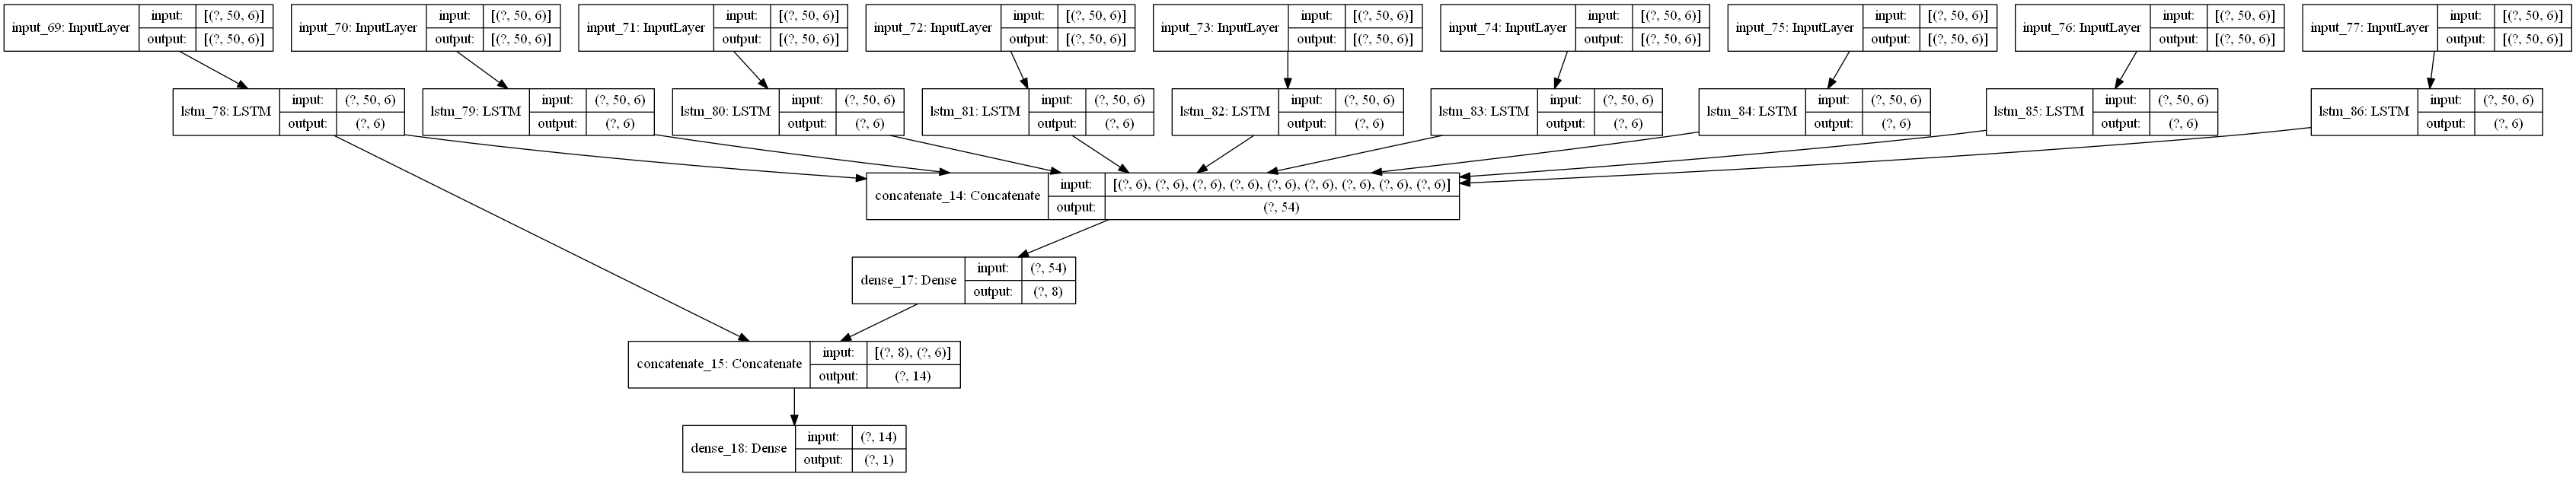

In [136]:
keras.utils.plot_model(model, show_shapes=True)

In [137]:
model.compile(optimizer='adam', loss='MSLE',metrics=['accuracy'])

In [146]:
history=model.fit(inputdatalstm,outputdata,epochs=200,batch_size=50,validation_split=0.1,verbose=1)

Train on 1742 samples, validate on 194 samples
Epoch 1/200
  50/1742 [..............................] - ETA: 3s - loss: 0.8116 - accuracy: 0.0000e+00 - val_loss: 0.4139 - val_accuracy: 0.0052Epoch 57/200


  50/1742 [..............................] - ETA: 3s - loss: 0.7388 - accuracy: 0.0000e+00 - val_loss: 0.3665 - val_accuracy: 0.0052Epoch 113/200


  50/1742 [..............................] - ETA: 3s - loss: 0.6869 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [139]:
test_scores = model.evaluate(inputdatalstm, outputdata, verbose=0)

In [149]:
test_scores = model.evaluate(inputdatalstm, outputdata, verbose=0)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Test loss: 0.025913375468293497
Test accuracy: 0.0


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


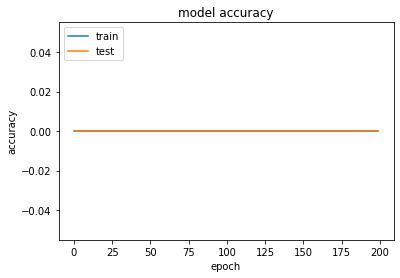

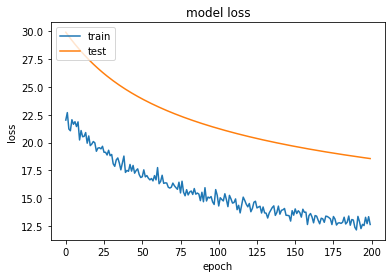

In [142]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

통합본
===============================

In [154]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
################################################################### data 조작용 parameters
n=5 #6이면 volume 도 사용
day=50 #한번에 볼 날자 수
################################################################### DATA 구성
D=[]
L=['AAPL','AMZN','BRK-B','FB','GOOG','GOOGL','JPM','MSFT','V']
maxdates=[]
for company in L:
    temp=np.genfromtxt('C:/Users/mod96/Desktop/HSH/DateSets/SP500top/'+company+'.csv', delimiter=',')
    temp2=np.size(temp,0)
    maxdates.append(temp2)
    D.append(temp[1:,1:])
maxdate=min(maxdates)

inputdata=[]
for i in range(len(L)):
    temp=maxdates[i]-maxdate
    temp2=maxdates[i]-2
    inputdata.append(D[i][temp:temp2,:n])

if n==5:
    inputdata=inputdata/max(max(max(inputdata)))
    
inputdatalstm=[]
for j in range(len(L)):
    inputdatalstm.append([])
    for i in range(np.size(inputdata[j],0)-day):
        k=i+day
        temp=inputdata[j][i:k,:]
        inputdatalstm[j].append(temp)

temp=maxdates[0]-maxdate+1+day
outputdata=D[0][temp:,0]
outputdata=outputdata/max(outputdata)

################################################################### 모델구성
inputseq=[];middle=[]
for i in range(len(L)):
    inputseq.append( keras.Input( shape=(day,n) ) )
    middle.append(layers.LSTM(6)(inputseq[i]))

x=layers.concatenate(middle)
x=layers.Dense(8, activation='sigmoid')(x)
x=layers.concatenate([x,middle[0]])
output=layers.Dense(1, activation='relu')(x)
model=keras.Model(inputs=inputseq,outputs=output)

model.compile(optimizer='adam', loss='MSLE',metrics=['accuracy'])
history=model.fit(inputdatalstm,outputdata,epochs=100,batch_size=4,verbose=1)

################################################################### 평가
test_scores = model.evaluate(inputdatalstm, outputdata, verbose=0)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

################################################################### 분석
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()